In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Dados

/content/drive/MyDrive/bootcamp/Averiguacao Cadastral/Dados


In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

In [4]:
# Load the datasets
df_familia_pessoas_final = pd.read_csv('df_familia_pessoas_final.csv',nrows=100000)
df_familia_pessoas_final = df_familia_pessoas_final.sample(10000)

In [5]:
# Selecionando as variáveis que serão utilizadas para o modelo
X = df_familia_pessoas_final [['qtd_pessoas', 'meses_trabalho','idade','idoso',
                               'cod_principal_trab_memb', 'trabalho_principal','cod_deficiencia_memb','qtd_meses_12_meses_memb', 'dias_cadastramento',
                               'uf_ibge']]

#X = df_familia_pessoas_final [['qtd_pessoas', 'idade',
#                               'cod_principal_trab_memb', 'trabalho_principal','cod_deficiencia_memb','qtd_meses_12_meses_memb']]

y = df_familia_pessoas_final['classe_renda']

# Exibindo as informações de X
print('X =', X.shape)
X.head()

X = (10000, 10)


,qtd_pessoas,meses_trabalho,idade,idoso,cod_principal_trab_memb,trabalho_principal,cod_deficiencia_memb,qtd_meses_12_meses_memb,dias_cadastramento,uf_ibge
6833,4,8.0,50,0,-1.0,1,2,-1.0,5772.0,26
23082,2,0.0,30,0,-1.0,0,2,-1.0,573.0,35
95400,2,-1.0,68,1,-1.0,0,2,-1.0,1748.0,29
76164,4,0.0,36,0,-1.0,0,2,-1.0,294.0,35
71822,3,0.0,44,0,-1.0,0,2,-1.0,5507.0,31


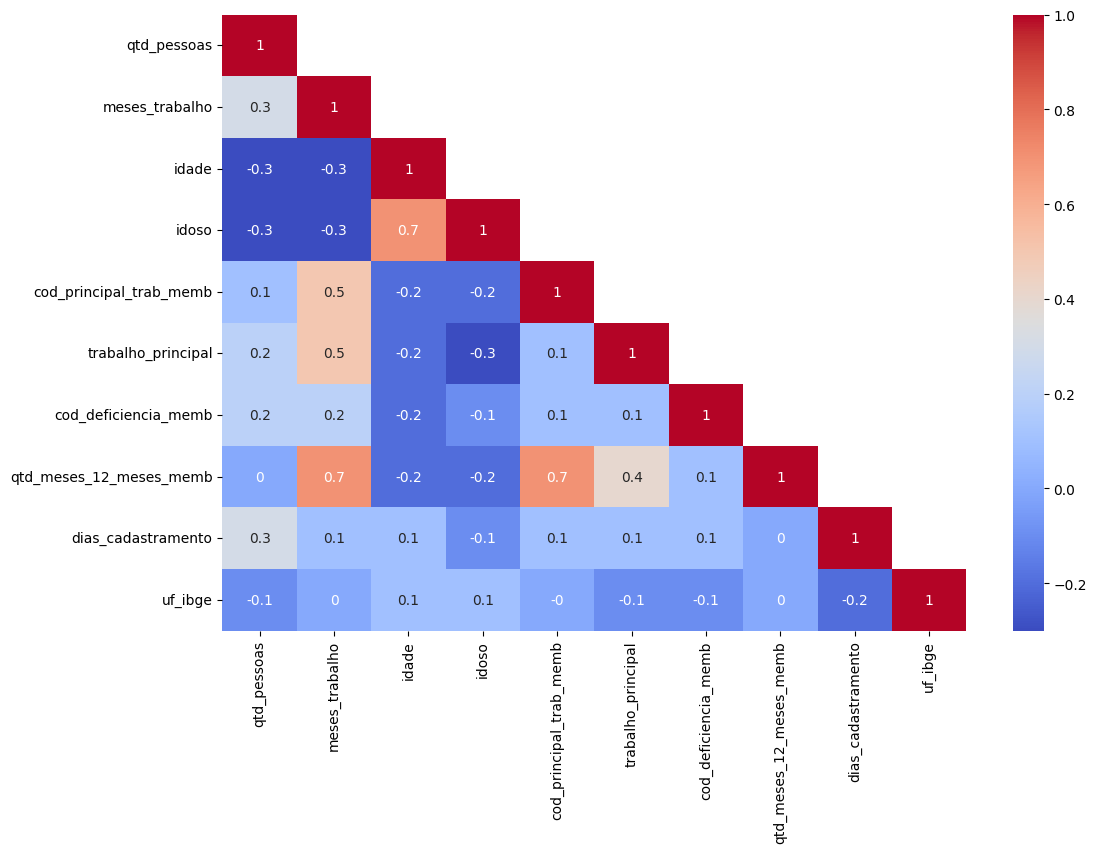

In [6]:
# Cria mask para não mostrar valores acima da diagonal
mask = np.triu(np.ones_like(X.corr(), dtype=bool), k=1)

plt.figure(figsize=(12,8))
sns.heatmap(X.corr().round(1), annot=True, cmap='coolwarm', mask=mask)
plt.show()

In [7]:
X.columns

Index(['qtd_pessoas', 'meses_trabalho', 'idade', 'idoso',
       'cod_principal_trab_memb', 'trabalho_principal', 'cod_deficiencia_memb',
       'qtd_meses_12_meses_memb', 'dias_cadastramento', 'uf_ibge'],
      dtype='object')

In [8]:
X.isnull().sum()

,0
qtd_pessoas,0
meses_trabalho,0
idade,0
idoso,0
cod_principal_trab_memb,0
trabalho_principal,0
cod_deficiencia_memb,0
qtd_meses_12_meses_memb,0
dias_cadastramento,0
uf_ibge,0


In [9]:
y.describe()

,classe_renda
count,10000.000000
mean,0.631000
std,0.804552
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [10]:
y.value_counts()

,count
classe_renda,
0.0,5762
1.0,2166
2.0,2072


In [11]:
y.isnull().sum()

0

In [12]:
# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [13]:
y_train.describe()

,classe_renda
count,8000.000000
mean,0.630875
std,0.804489
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


In [14]:
# Mapeando y_train e y_test se necessário (exemplo)
y_train_mapped = y_train.astype('int')
y_test_mapped = y_test.astype('int')

In [15]:
y_train_mapped.describe()

,classe_renda
count,8000.000000
mean,0.630875
std,0.804489
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,2.000000


# Fazendo um pipeline comparando diversos modelos

In [16]:
!pip install xgboost -q

In [17]:
!pip install catboost -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.1 MB/s eta 0:00:00


In [18]:
# Importações necessárias
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier

# 1. Definição dos Modelos

In [19]:
# Definir os modelos e os parâmetros
models = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(silent=True),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    }
}

# 2. Treinamento e Busca de Hiperparâmetros

In [20]:
# Criar um dicionário para armazenar os melhores modelos
best_models = {}

for model_name, model_info in models.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_train, y_train_mapped)

    # Armazenar o melhor modelo
    best_models[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name}: {grid_search.best_params_}")

Melhores hiperparâmetros para DecisionTree: {'classifier__max_depth': 7, 'classifier__min_samples_split': 5}
Melhores hiperparâmetros para RandomForest: {'classifier__max_depth': 10, 'classifier__n_estimators': 100}
Melhores hiperparâmetros para XGBoost: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__n_estimators': 300}
Melhores hiperparâmetros para CatBoost: {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}


# 3. Avaliação do Modelo

In [21]:
from sklearn.metrics import accuracy_score, f1_score

In [22]:
# Avaliar todos os modelos
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score
    f1 = f1_score(y_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_test, y_pred)

    # Exibir os resultados
    print(f"Modelo: {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo: DecisionTree
  F1 Score: 0.67
  Acurácia: 0.75
Modelo: RandomForest
  F1 Score: 0.70
  Acurácia: 0.77
Modelo: XGBoost
  F1 Score: 0.71
  Acurácia: 0.78
Modelo: CatBoost
  F1 Score: 0.71
  Acurácia: 0.78


# 4. Geração de Matriz de Confusão

In [23]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

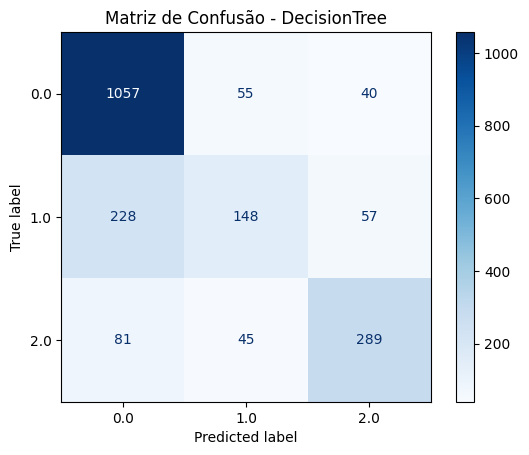

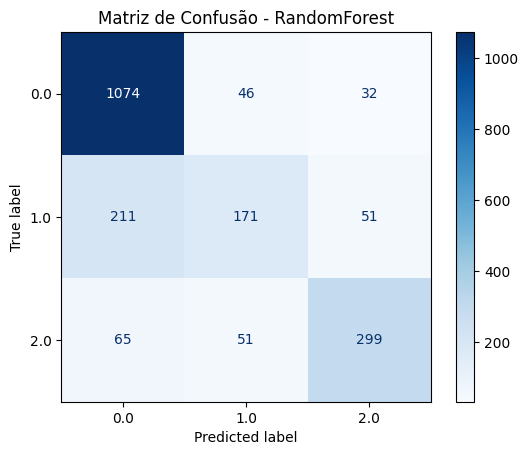

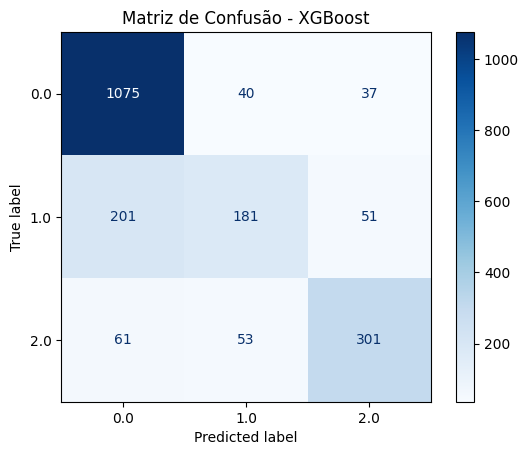

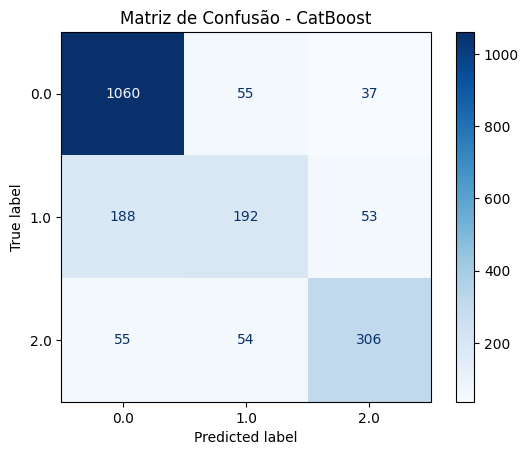

In [24]:
# Gerar matriz de confusão para cada modelo
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    ConfusionMatrixDisplay.from_estimator(model, X_test, y_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name}')
    plt.show()

# 5. Análise da Importância das Features

In [25]:
import numpy as np
from sklearn.inspection import permutation_importance

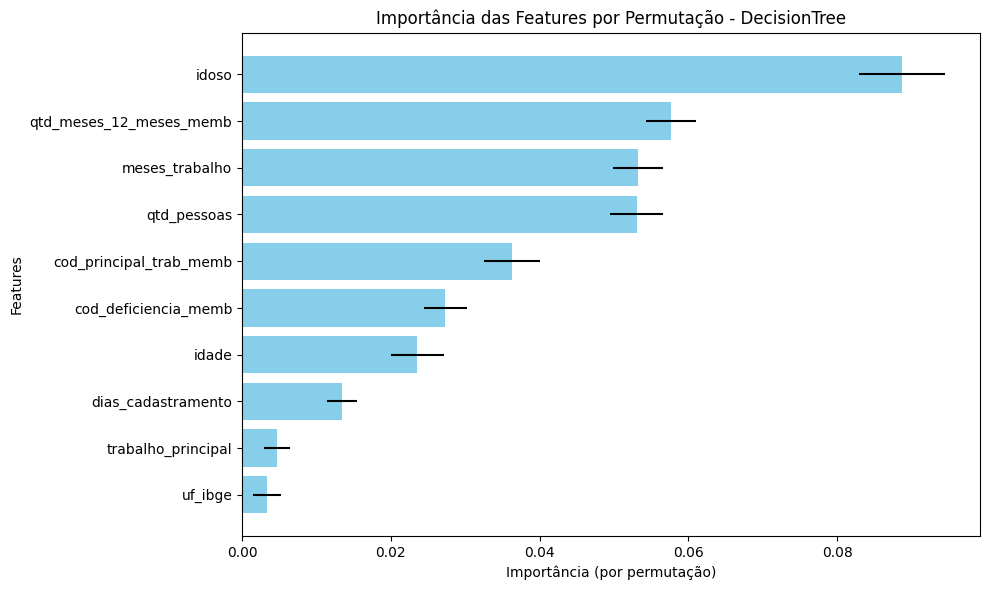

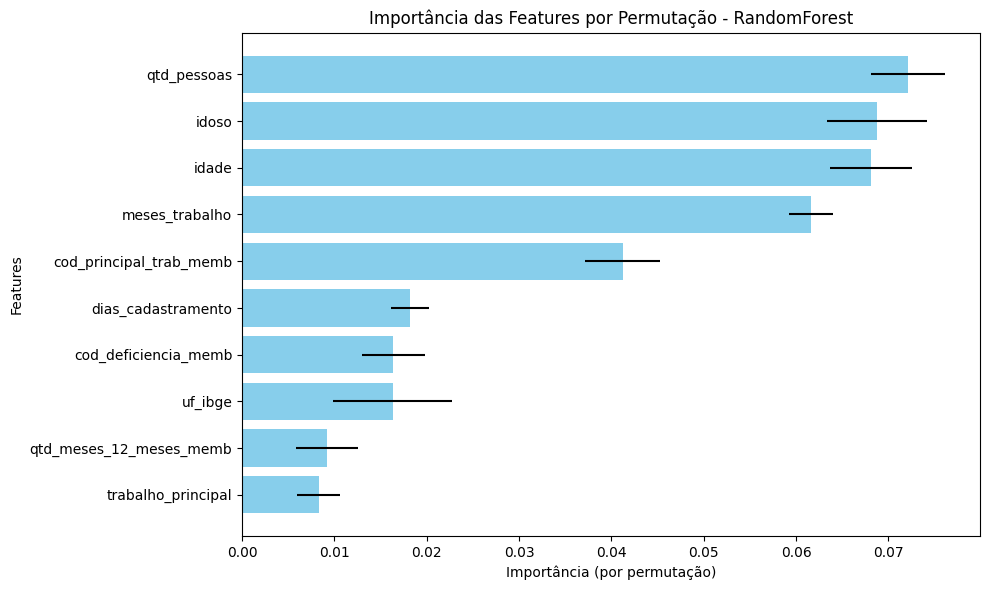

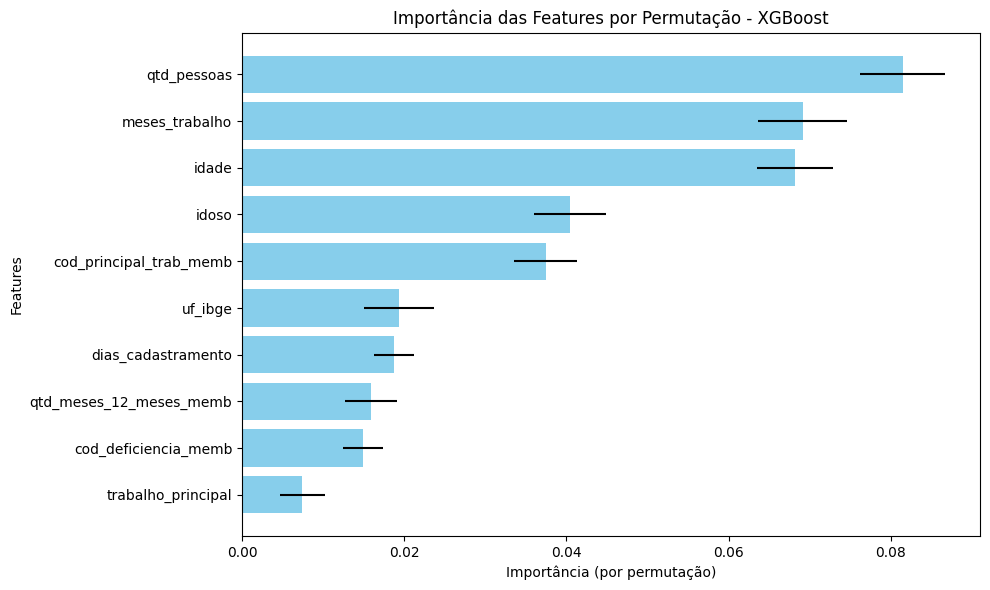

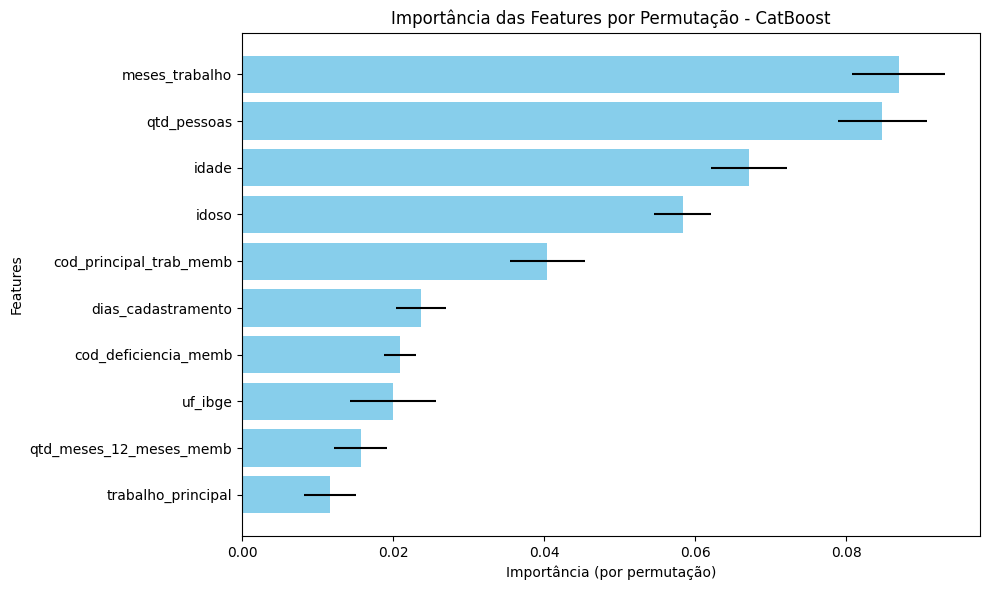

In [26]:
# Importância das features para cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name}")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()

In [27]:
# Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo
for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:5]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n5 Features mais importantes para o modelo {model_name}:")
    print(top_features_df)


5 Features mais importantes para o modelo DecisionTree:
                   Feature  Importância
0                    idoso      0.08870
1  qtd_meses_12_meses_memb      0.05765
2           meses_trabalho      0.05325
3              qtd_pessoas      0.05305
4  cod_principal_trab_memb      0.03625

5 Features mais importantes para o modelo RandomForest:
                   Feature  Importância
0              qtd_pessoas      0.07210
1                    idoso      0.06875
2                    idade      0.06810
3           meses_trabalho      0.06160
4  cod_principal_trab_memb      0.04125

5 Features mais importantes para o modelo XGBoost:
                   Feature  Importância
0              qtd_pessoas      0.08145
1           meses_trabalho      0.06915
2                    idade      0.06815
3                    idoso      0.04045
4  cod_principal_trab_memb      0.03745

5 Features mais importantes para o modelo CatBoost:
                   Feature  Importância
0           meses_tra

# Avaliando o balanceamento das classes

In [28]:
# Verificar a distribuição da variável target
target_distribution = y.value_counts(normalize=True)

In [29]:
print("Distribuição da variável target 'classe_renda':")
print(target_distribution)

Distribuição da variável target 'classe_renda':
classe_renda
0.0    0.5762
1.0    0.2166
2.0    0.2072
Name: proportion, dtype: float64


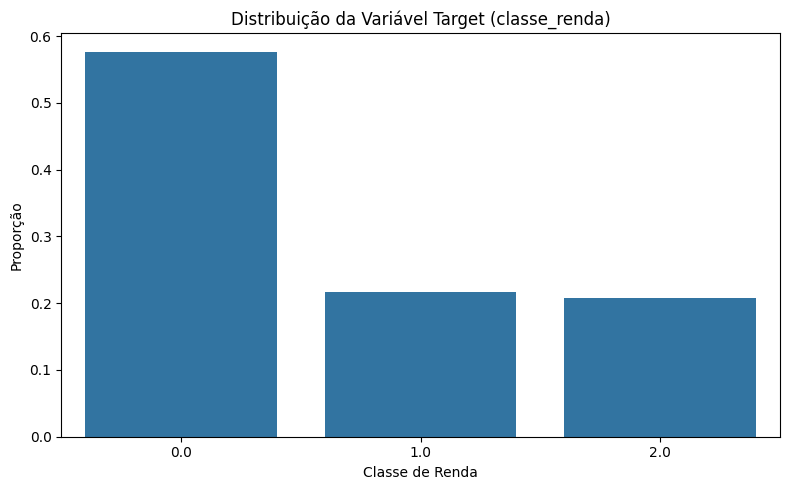

In [30]:
# Plotar a distribuição da variável target
plt.figure(figsize=(8, 5))
sns.barplot(x=target_distribution.index, y=target_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda)')
plt.xlabel('Classe de Renda')
plt.ylabel('Proporção')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

In [31]:
# Exibir o número absoluto de ocorrências por classe
absolute_distribution = y.value_counts()

print("\nNúmero absoluto de ocorrências por classe:")
print(absolute_distribution)


Número absoluto de ocorrências por classe:
classe_renda
0.0    5762
1.0    2166
2.0    2072
Name: count, dtype: int64


## Balanceando as classes

In [32]:
pip install imbalanced-learn

In [33]:
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

In [34]:
df_familia_pessoas_final.classe_renda.value_counts()

,count
classe_renda,
0.0,5762
1.0,2166
2.0,2072


In [35]:
y.value_counts()

,count
classe_renda,
0.0,5762
1.0,2166
2.0,2072


In [36]:
# Suponha que 'y' seja sua variável alvo e '0.0' seja a classe majoritária
n_samples_majority = y.value_counts()[0.0]

# Oversampling da classe '1.0' para 30% da classe majoritária
n_samples_1 = int(0.9 * n_samples_majority)

# Oversampling da classe '2.0' para 40% da classe majoritária
n_samples_2 = int(0.9 * n_samples_majority)

# Undersampling da classe '0.0' para 70% do tamanho original
n_samples_0 = int(1.0 * n_samples_majority)

over = SMOTE(sampling_strategy={1.0: n_samples_1, 2.0: n_samples_2})
under = RandomUnderSampler(sampling_strategy={0.0: n_samples_0})

In [37]:
# Criar um pipeline que aplica SMOTE e depois o undersampling
pipeline = Pipeline(steps=[('o', over), ('u', under)])

In [38]:
# Aplicar o balanceamento ao conjunto de dados
X_balanced, y_balanced = pipeline.fit_resample(X, y)

In [39]:
# Verificar a nova distribuição das classes
balanced_distribution = pd.Series(y_balanced).value_counts()

print("Distribuição da variável target 'classe_renda' após o balanceamento:")
print(balanced_distribution)

Distribuição da variável target 'classe_renda' após o balanceamento:
classe_renda
0.0    5762
1.0    5185
2.0    5185
Name: count, dtype: int64


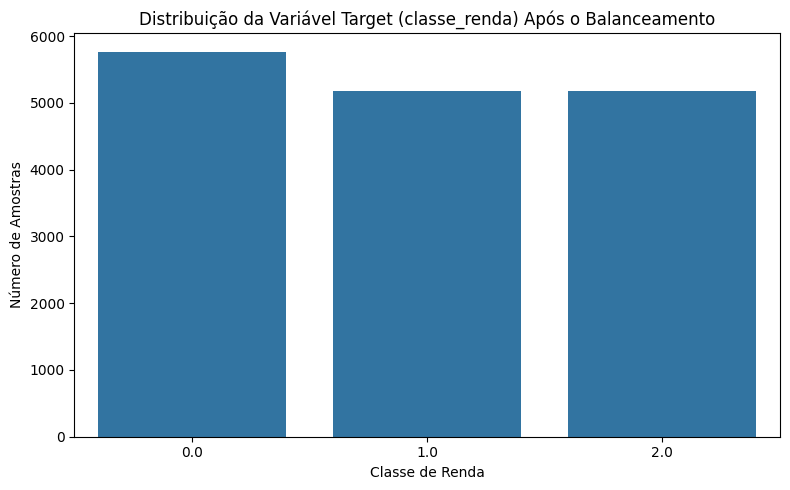

In [40]:
# Visualizar a distribuição das classes após o balanceamento
plt.figure(figsize=(8, 5))
sns.barplot(x=balanced_distribution.index, y=balanced_distribution.values)
plt.title('Distribuição da Variável Target (classe_renda) Após o Balanceamento')
plt.xlabel('Classe de Renda')
plt.ylabel('Número de Amostras')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Refazendo as análises dos modelos após balanceamento das classes

In [41]:
X_balanced.head()

,qtd_pessoas,meses_trabalho,idade,idoso,cod_principal_trab_memb,trabalho_principal,cod_deficiencia_memb,qtd_meses_12_meses_memb,dias_cadastramento,uf_ibge
8223,2,12.0,38,0,-1.0,1,2,-1.0,6198.0,23
7960,3,0.0,37,0,-1.0,0,2,-1.0,831.0,33
234,2,12.0,42,0,1.0,1,2,12.0,4487.0,43
2545,2,0.0,18,0,-1.0,0,2,-1.0,493.0,31
8703,1,-1.0,31,0,-1.0,0,2,-1.0,392.0,31


In [42]:
print(X_balanced.shape)
print(y_balanced.shape)

(16132, 10)
(16132,)


In [43]:
print(y_balanced.shape)
print(y.shape)  # Verifique se y é igual a y_balanced

(16132,)
(10000,)


In [44]:
# Dividir os dados em treino e teste após balanceamento
X_balanced_train, X_balanced_test, y_balanced_train, y_balanced_test = train_test_split(X_balanced, y_balanced, test_size=0.2, random_state=42)

In [45]:
# Definir os modelos e os parâmetros
models_balanced = {
    'DecisionTree': {
        'model': DecisionTreeClassifier(),
        'param_grid': {
            'classifier__max_depth': [3, 5, 7],
            'classifier__min_samples_split': [2, 5, 10]
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'param_grid': {
            'classifier__n_estimators': [100, 200],
            'classifier__max_depth': [None, 10, 20]
        }
    },
    'XGBoost': {
        'model': XGBClassifier(objective='multi:softmax', num_class=3, random_state=42),
        'param_grid': {
            'classifier__n_estimators': [250, 300],
            'classifier__max_depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    },
    'CatBoost': {
        'model': CatBoostClassifier(silent=True),
        'param_grid': {
            'classifier__iterations': [250, 500],
            'classifier__depth': [3, 5],
            'classifier__learning_rate': [0.1]
        }
    }
}



In [46]:
# Parte 3: Criar um dicionário para armazenar os melhores modelos
best_models_balanced = {}

for model_name, model_info in models_balanced.items():
    # Criar o pipeline
    pipeline = Pipeline([
        ('scaler', StandardScaler()),
        ('classifier', model_info['model'])
    ])

    # Definir GridSearchCV usando as features e classes balanceadas
    grid_search = GridSearchCV(pipeline, model_info['param_grid'], cv=3, scoring='f1_macro', n_jobs=-1)
    grid_search.fit(X_balanced_train, y_balanced_train)  # Usando dados balanceados

    # Armazenar o melhor modelo
    best_models_balanced[model_name] = grid_search.best_estimator_
    print(f"Melhores hiperparâmetros para {model_name} (usando dados balanceados): {grid_search.best_params_}")



Melhores hiperparâmetros para DecisionTree (usando dados balanceados): {'classifier__max_depth': 7, 'classifier__min_samples_split': 2}
Melhores hiperparâmetros para RandomForest (usando dados balanceados): {'classifier__max_depth': 20, 'classifier__n_estimators': 100}
Melhores hiperparâmetros para XGBoost (usando dados balanceados): {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 300}
Melhores hiperparâmetros para CatBoost (usando dados balanceados): {'classifier__depth': 5, 'classifier__iterations': 500, 'classifier__learning_rate': 0.1}


In [47]:
# Parte 4: Avaliar todos os modelos usando dados balanceados
from sklearn.metrics import f1_score, accuracy_score
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usando dados de teste balanceados

    # Calcular F1 Score
    f1 = f1_score(y_balanced_test, y_pred, average='macro')

    # Calcular Acurácia
    accuracy = accuracy_score(y_balanced_test, y_pred)

    # Exibir os resultados
    print(f"Modelo (usando dados balanceados): {model_name}")
    print(f"  F1 Score: {f1:.2f}")
    print(f"  Acurácia: {accuracy:.2f}")


Modelo (usando dados balanceados): DecisionTree
  F1 Score: 0.73
  Acurácia: 0.73
Modelo (usando dados balanceados): RandomForest
  F1 Score: 0.80
  Acurácia: 0.80
Modelo (usando dados balanceados): XGBoost
  F1 Score: 0.80
  Acurácia: 0.80
Modelo (usando dados balanceados): CatBoost
  F1 Score: 0.79
  Acurácia: 0.79


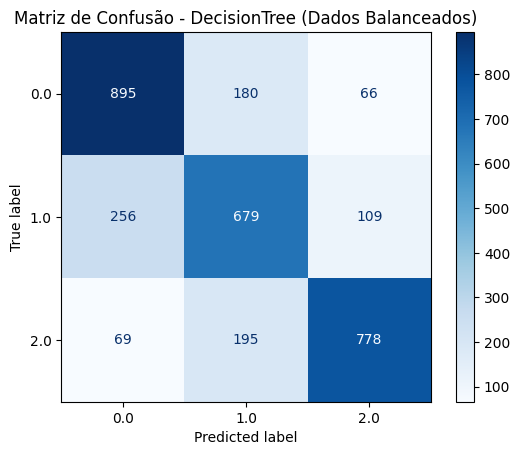

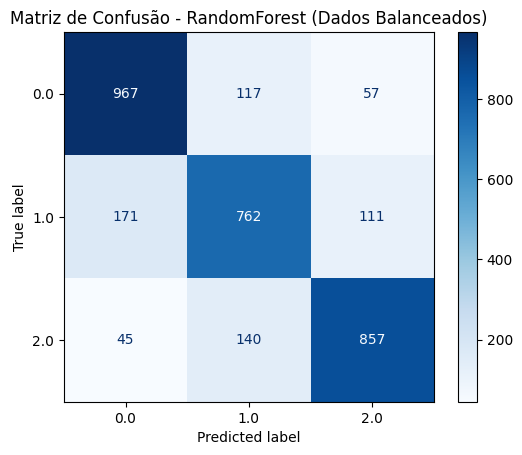

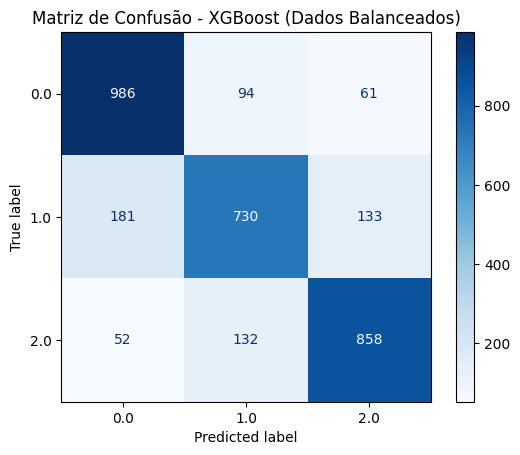

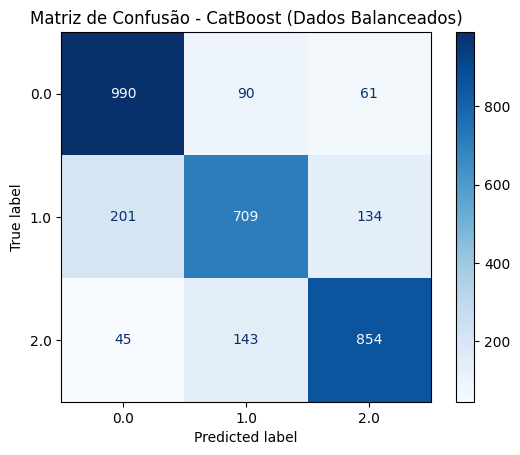

In [48]:
# Parte 5: Gerar matriz de confusão para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    y_pred = model.predict(X_balanced_test)  # Usar os dados de teste balanceados

    # Gerar a matriz de confusão
    ConfusionMatrixDisplay.from_estimator(model, X_balanced_test, y_balanced_test, cmap='Blues')
    plt.title(f'Matriz de Confusão - {model_name} (Dados Balanceados)')
    plt.show()

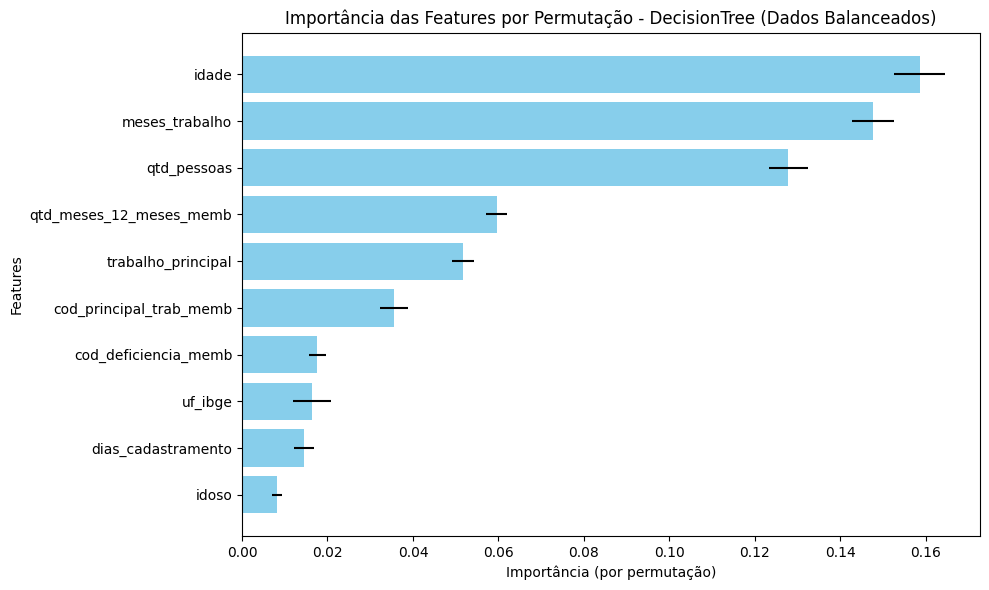

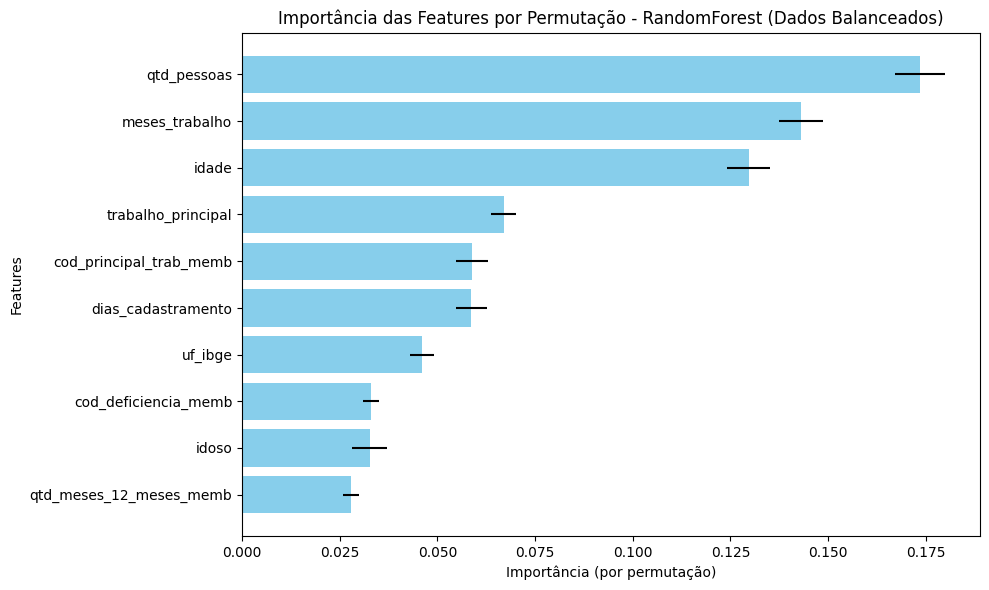

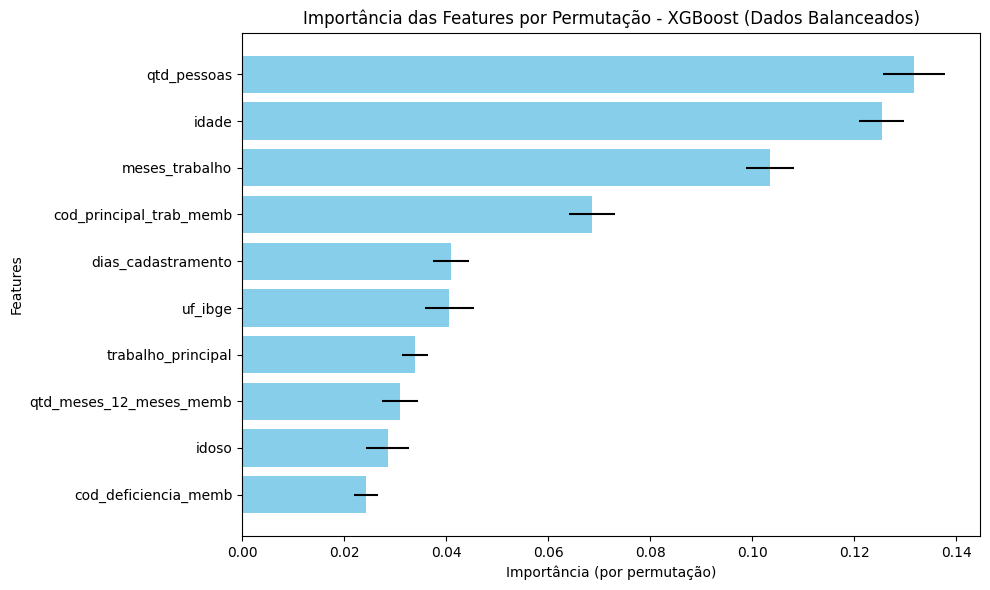

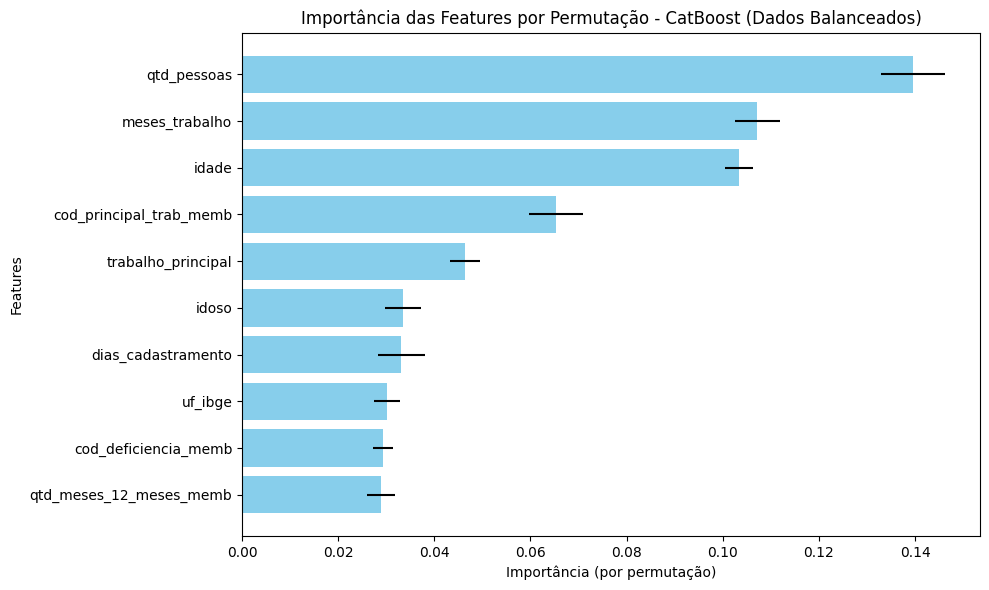

In [49]:
# Parte 6: Importância das features para cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Ordenar importâncias
    importance_vals = perm_importance.importances_mean
    importance_std = perm_importance.importances_std
    indices = np.argsort(importance_vals)[::-1]

    # Plotar
    plt.figure(figsize=(10, 6))
    plt.title(f"Importância das Features por Permutação - {model_name} (Dados Balanceados)")
    plt.barh(range(len(importance_vals)), importance_vals[indices], xerr=importance_std[indices], align="center", color='skyblue')
    plt.yticks(range(len(importance_vals)), X_balanced_test.columns[indices])
    plt.gca().invert_yaxis()
    plt.xlabel('Importância (por permutação)')
    plt.ylabel('Features')
    plt.tight_layout()
    plt.show()



In [50]:
# Parte 7: Lista para armazenar as 5 principais features de cada modelo
top_features_list = {}

# Obter as 5 features mais importantes de cada modelo usando dados balanceados
for model_name, model in best_models_balanced.items():
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair valores de importância e índices
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Obter as 5 principais features e suas importâncias
    top_indices = indices[:5]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Armazenar em um DataFrame
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Adicionar ao dicionário
    top_features_list[model_name] = top_features_df

# Exibir as 5 principais features de cada modelo
for model_name, top_features_df in top_features_list.items():
    print(f"\n5 Features mais importantes para o modelo {model_name} (Dados Balanceados):")
    print(top_features_df)



5 Features mais importantes para o modelo DecisionTree (Dados Balanceados):
                   Feature  Importância
0                    idade     0.158568
1           meses_trabalho     0.147598
2              qtd_pessoas     0.127828
3  qtd_meses_12_meses_memb     0.059622
4       trabalho_principal     0.051782

5 Features mais importantes para o modelo RandomForest (Dados Balanceados):
                   Feature  Importância
0              qtd_pessoas     0.173443
1           meses_trabalho     0.143043
2                    idade     0.129625
3       trabalho_principal     0.066935
4  cod_principal_trab_memb     0.058754

5 Features mais importantes para o modelo XGBoost (Dados Balanceados):
                   Feature  Importância
0              qtd_pessoas     0.131670
1                    idade     0.125349
2           meses_trabalho     0.103502
3  cod_principal_trab_memb     0.068578
4       dias_cadastramento     0.040936

5 Features mais importantes para o modelo CatBoost (D

# Comparando a performance antes e após o balanceamento

In [51]:
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score
from sklearn.inspection import permutation_importance

In [52]:
# Lista para armazenar as métricas de desempenho
performance_comparison = []

# Avaliar modelos antes do balanceamento
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)

    # Calcular F1 Score e Acurácia
    f1_before = f1_score(y_test, y_pred, average='macro')
    accuracy_before = accuracy_score(y_test, y_pred)

    # Armazenar os resultados antes do balanceamento
    performance_comparison.append({
        'Modelo': model_name,
        'F1 Score Antes do Balanceamento': f1_before,
        'Acurácia Antes do Balanceamento': accuracy_before,
        'F1 Score Após o Balanceamento': None,  # Inicializa como None
        'Acurácia Após o Balanceamento': None,  # Inicializa como None
    })


In [53]:
# Avaliar modelos após o balanceamento
for model_name, model in best_models_balanced.items():
    y_pred_balanced = model.predict(X_balanced_test)

    # Calcular F1 Score e Acurácia
    f1_balanced = f1_score(y_balanced_test, y_pred_balanced, average='macro')
    accuracy_after = accuracy_score(y_balanced_test, y_pred_balanced)

    # Adicionar os resultados após o balanceamento ao mesmo dicionário
    for entry in performance_comparison:
        if entry['Modelo'] == model_name:
            entry['F1 Score Após o Balanceamento'] = f1_balanced
            entry['Acurácia Após o Balanceamento'] = accuracy_after



In [54]:
# Criar DataFrame para as métricas de desempenho
performance_df = pd.DataFrame(performance_comparison)

# Exibir o DataFrame de desempenho
performance_df.head(10)


,Modelo,F1 Score Antes do Balanceamento,Acurácia Antes do Balanceamento,F1 Score Após o Balanceamento,Acurácia Após o Balanceamento
0,DecisionTree,0.665269,0.7470,0.728462,0.728850
1,RandomForest,0.698900,0.7720,0.800046,0.801363
2,XGBoost,0.708193,0.7785,0.795026,0.797645
3,CatBoost,0.713776,0.7790,0.787938,0.791137


In [55]:
# Obter as 5 features mais importantes antes do balanceamento
top_features_before = {}

for model_name, model in best_models.items():
    perm_importance = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    top_indices = indices[:5]
    top_features = X_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    top_features_before[model_name] = top_features_df



In [56]:
# Obter as 5 features mais importantes após o balanceamento
top_features_after = {}

for model_name, model in best_models_balanced.items():
    # Calcular a importância das features usando o conjunto de dados balanceado
    perm_importance = permutation_importance(model, X_balanced_test, y_balanced_test, n_repeats=10, random_state=42)

    # Extrair os valores de importância
    importance_vals = perm_importance.importances_mean
    indices = np.argsort(importance_vals)[::-1]

    # Selecionar os 5 índices mais importantes
    top_indices = indices[:5]
    top_features = X_balanced_test.columns[top_indices]
    top_importances = importance_vals[top_indices]

    # Criar DataFrame para armazenar as features e suas importâncias
    top_features_df = pd.DataFrame({
        'Feature': top_features,
        'Importância': top_importances
    })

    # Armazenar o DataFrame na lista de modelos
    top_features_after[model_name] = top_features_df




In [57]:
# Criar DataFrame para as features mais importantes antes e após o balanceamento
top_features_before_df = pd.concat(top_features_before, names=['Modelo', 'Índice']).reset_index()
top_features_after_df = pd.concat(top_features_after, names=['Modelo', 'Índice']).reset_index()

In [58]:
top_features_before_df.head(20)

,Modelo,Índice,Feature,Importância
0,DecisionTree,0,idoso,0.08870
1,DecisionTree,1,qtd_meses_12_meses_memb,0.05765
2,DecisionTree,2,meses_trabalho,0.05325
3,DecisionTree,3,qtd_pessoas,0.05305
4,DecisionTree,4,cod_principal_trab_memb,0.03625
5,RandomForest,0,qtd_pessoas,0.07210
6,RandomForest,1,idoso,0.06875
7,RandomForest,2,idade,0.06810
8,RandomForest,3,meses_trabalho,0.06160
9,RandomForest,4,cod_principal_trab_memb,0.04125


In [59]:
top_features_after_df.head(20)

,Modelo,Índice,Feature,Importância
0,DecisionTree,0,idade,0.158568
1,DecisionTree,1,meses_trabalho,0.147598
2,DecisionTree,2,qtd_pessoas,0.127828
3,DecisionTree,3,qtd_meses_12_meses_memb,0.059622
4,DecisionTree,4,trabalho_principal,0.051782
5,RandomForest,0,qtd_pessoas,0.173443
6,RandomForest,1,meses_trabalho,0.143043
7,RandomForest,2,idade,0.129625
8,RandomForest,3,trabalho_principal,0.066935
9,RandomForest,4,cod_principal_trab_memb,0.058754


In [60]:
# Combinar em um único dataframe

# Criar um DataFrame vazio para armazenar o resultado
combined_df = pd.DataFrame()

# Iterar sobre os modelos únicos
for modelo in top_features_before_df['Modelo'].unique():
    # Obter as 5 features mais importantes antes e após o balanceamento
    antes = top_features_before_df[top_features_before_df['Modelo'] == modelo].reset_index(drop=True)
    depois = top_features_after_df[top_features_after_df['Modelo'] == modelo].reset_index(drop=True)

    # Adicionar as features antes e depois ao DataFrame combinado
    for i in range(5):  # Para as 5 features mais importantes
        combined_df = pd.concat([combined_df, pd.DataFrame({
            'Modelo': modelo,
            'Feature Antes': antes['Feature'][i],
            'Importância Antes': antes['Importância'][i],
            'Feature Após': depois['Feature'][i],
            'Importância Após': depois['Importância'][i]
        }, index=[0])], ignore_index=True)


In [61]:
 combined_df.head(20)

,Modelo,Feature Antes,Importância Antes,Feature Após,Importância Após
0,DecisionTree,idoso,0.08870,idade,0.158568
1,DecisionTree,qtd_meses_12_meses_memb,0.05765,meses_trabalho,0.147598
2,DecisionTree,meses_trabalho,0.05325,qtd_pessoas,0.127828
3,DecisionTree,qtd_pessoas,0.05305,qtd_meses_12_meses_memb,0.059622
4,DecisionTree,cod_principal_trab_memb,0.03625,trabalho_principal,0.051782
5,RandomForest,qtd_pessoas,0.07210,qtd_pessoas,0.173443
6,RandomForest,idoso,0.06875,meses_trabalho,0.143043
7,RandomForest,idade,0.06810,idade,0.129625
8,RandomForest,meses_trabalho,0.06160,trabalho_principal,0.066935
9,RandomForest,cod_principal_trab_memb,0.04125,cod_principal_trab_memb,0.058754
